### Задача:

На основе данных узнать, можно ли использовать для стат.оценки критерий Стьюдента.     
Метрика – ARPU    
В процессе решения задачи необходимо ответить на следующие вопросы:     
1) Как распределена t статистика при верности нулевой гипотезы   
2) Как распределен pValue при верности нулевой гипотезы     
3) Как распределена разница средних  

Ответы:     
1) Симметрично   
2) Равномерно   
3) Нормально

In [1]:
import pandas as pd
import numpy as np
# виз
from tqdm import tqdm  
from time import sleep 
import matplotlib.pyplot as plt
# стат
from scipy.stats import norm
from scipy import stats

In [2]:
df = pd.read_csv('skyeng_day2.csv') 

In [3]:
df.head()

,user,check
0,67499.158175,0.0
1,83340.158176,0.0
2,85529.158172,0.0
3,197806.157903,0.0
4,221230.158178,0.0


In [4]:
# первая половина выборки
data_column_1 = df.sample(frac = 0.5)
 
# вторая половина выборки
data_column_2 = df.drop(data_column_1.index)

### Распределение разницы средних

In [5]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):

    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_2), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 819.87it/s]


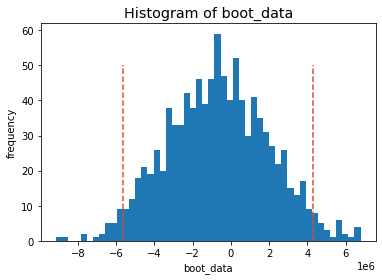

{'boot_data': [-4393640.65824455,
  -1226689.2945307493,
  1615418.6422462463,
  -3581312.5002526045,
  -812062.3883376122,
  -2442988.8860280514,
  -4646098.847344756,
  -1865030.366668582,
  772663.3143179417,
  -2627610.054823756,
  -83840.15548479557,
  -6236535.143144608,
  271281.9940864444,
  550645.7318323851,
  -1236202.4573339224,
  1153598.7561548948,
  -2020638.242756486,
  6779239.077167928,
  -3114486.186739862,
  3113276.0576996207,
  3655919.9653736353,
  2489599.8430948257,
  -2577800.9705507755,
  -1974929.6864321232,
  -464191.95870250463,
  157719.82709759474,
  -1592151.0661652684,
  -5176862.146650016,
  -5794514.959002435,
  -803815.8274893761,
  1784192.9861593246,
  3329144.5953511,
  1176663.4155973792,
  -3172204.547307074,
  2527114.3451778293,
  3801967.2536114454,
  3412562.2464305162,
  -1406232.6463997364,
  -4899856.120704532,
  -3964131.8279452324,
  1525772.5221604705,
  410272.83730095625,
  2623234.8793700337,
  -3525100.100601554,
  3425764.4793969

In [6]:
get_bootstrap(data_column_1, data_column_2, boot_it = 1000, statistic = np.mean, bootstrap_conf_level = 0.95)

### Распределение pValue, t статистики и fpr (на рандоме exponential)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 248.98it/s]


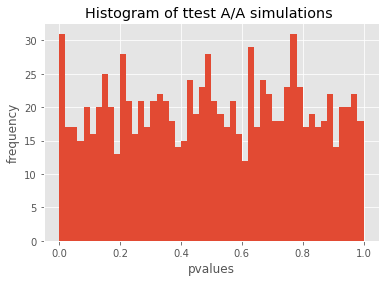

In [7]:
n = 100000
simulations = 1000
n_s = 1000
res = []

df = pd.DataFrame({
    "s1": np.random.exponential(scale=1/0.001, size=n),
    "s2": np.random.exponential(scale=1/0.001, size=n)
})


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df['s1'].sample(n_s, replace = False).values
    s2 = df['s2'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [8]:
# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

0.058

In [9]:
sum(np.array(res) <0.01) / simulations

0.009

In [10]:
sum(np.array(res) <0.1) / simulations

0.099

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 250.46it/s]


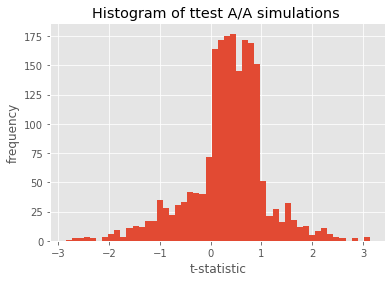

In [11]:
# Запуск симуляций A/A теста
# Распределение t статистики
for i in tqdm(range(simulations)):
    s1 = df['s1'].sample(n_s, replace = False).values
    s2 = df['s2'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[0]) # сохраняем t-статистику

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('t-statistic')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

### Распределение pValue, t статистики и fpr (на заданном датасорсе)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 689.64it/s]


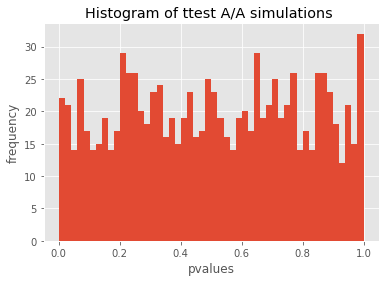

In [12]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
# Распределение pValue
for i in tqdm(range(simulations)):
    s1 = data_column_1['check'].sample(n_s, replace = False).values
    s2 = data_column_2['check'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [13]:
# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

0.046

In [14]:
sum(np.array(res) <0.01) / simulations

0.008

In [15]:
sum(np.array(res) <0.1) / simulations

0.099

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 248.30it/s]


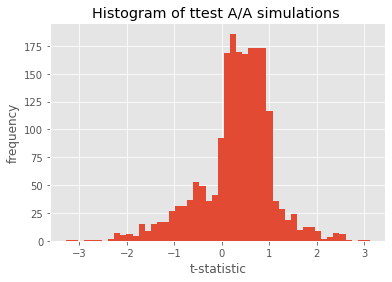

In [16]:
# Запуск симуляций A/A теста
# Распределение t статистики
for i in tqdm(range(simulations)):
    s1 = df['s1'].sample(n_s, replace = False).values
    s2 = df['s2'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[0]) # сохраняем t-статистику

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('t-statistic')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()